###Deep Learning Notebook

In this notebook, we define various models, then train and test the transformed dataset. The end goal of our model is to improve on pre-train models, compare to our original model baseline, and measure the impact of image size on model accuracy.

####1. Process Description

We started building our own CNN model that integrated skip forward to fully connected layer. We then use the outcome of our model and compares with the performance of improved ResNet and DenseNet. During this process, since we already generated the transformed dataset, we can skip the transformation part and load the data directly.

We first started with mounting to the correct Azure Data Lake Storage:

- **/mnt/output**: mounting alias for model output and plot images
- **/mnt/dim**: excel dataset about the patients
- **/mnt/datasets**: transformed dataset

In [0]:
#mount dimension container 
try:
  dbutils.fs.mount(
    source = "wasbs://dimension@chestxraystorage1.blob.core.windows.net", #change images-sample to images to connect to all images
    mount_point = "/mnt/dim",
    extra_configs = {"fs.azure.account.key.chestxraystorage1.blob.core.windows.net":"VtYP71BSCTyhUtCeGkMSmRRnAvTPVC3v4RxDy9sQEBOdtWCWF2BWp4lsEm0iSkLI1/pmfKO3GrjWVfMCjTD1MA=="})
except:
  print('Already mounted')
  
  
#mount datasets container 
try:
  dbutils.fs.mount(
    source = "wasbs://datasets@chestxraystorage1.blob.core.windows.net", #change images-sample to images to connect to all images
    mount_point = "/mnt/datasets",
    extra_configs = {"fs.azure.account.key.chestxraystorage1.blob.core.windows.net":"VtYP71BSCTyhUtCeGkMSmRRnAvTPVC3v4RxDy9sQEBOdtWCWF2BWp4lsEm0iSkLI1/pmfKO3GrjWVfMCjTD1MA=="})
except:
  print('Already mounted')
  
  
#mount output container 
try:
  dbutils.fs.mount(
    source = "wasbs://output@chestxray2.blob.core.windows.net", #change images-sample to images to connect to all images
    mount_point = "/mnt/output",
    extra_configs = {"fs.azure.account.key.chestxray2.blob.core.windows.net":"JKSEUUF32ek7eIoQIWRiC4jFzZbdBDKGhcJoowGY0/3G3RRYFv/nt21MoG+jBqPloNxEP8GHSwuysFDlrZr7Og=="})
except:
  print('Already mounted')

Already mounted
Already mounted
Already mounted

Import needed packaged. In this implementation, we leverage Petastorm as helper ultilities to convert spark dataframe to Dataloader

In [0]:
#Add needed packages
import math
import io
import numpy as np
import torch
import torch.optim as optim
import torchvision
import pandas as pd

from petastorm.spark import SparkDatasetConverter, make_spark_converter

from pyspark.sql.functions import *
from pyspark import SparkContext

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

from tensorflow.keras.layers import Conv2D,Flatten,Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50 as ResNet50_Keras
import torchvision.models as models
from torchvision.models.resnet import ResNet, BasicBlock

import os
import time

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as sklm
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math



####2. Model Defination

In this section, we declare our models. Although there are multiple models defined here, the three most important models we used are:
- **MyCNN1**
- **DenseNet_Torch_Freeze**
- **RestNet_Torch_Freeze**

In [0]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        #self.input_size = 256
        self.input_size = 256
        self.kernel_size1 = 3
        self.kernel_size2 = 3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=self.kernel_size1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, self.kernel_size2)
        self.fc1 = nn.Linear(in_features=((((self.input_size-self.kernel_size1+1-2)//2+1)-self.kernel_size2+1-2)//2+1) * \
                             ((((self.input_size-self.kernel_size1+1-2)//2+1)-self.kernel_size2+1-2)//2+1) * 32, out_features=128)
        self.fc2 = nn.Linear(128, 64)
        #self.fc3 = nn.Linear(64, 2) # single output

        self.fc3 = nn.Linear(64, 14) # multiple output (14 labels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, ((((self.input_size-self.kernel_size1+1-2)//2+1)-self.kernel_size2+1-2)//2+1) * \
                   ((((self.input_size-self.kernel_size1+1-2)//2+1)-self.kernel_size2+1-2)//2+1) * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # Only for BCE
        #x = torch.sigmoid(x)
        #print(x)
        return x
      
class MyCNN1(nn.Module):
    def __init__(self, input_size = 256):
        super(MyCNN1, self).__init__()
        #self.input_size = 256
        self.input_size = input_size
        self.kernel_size1 = 3
        self.kernel_size2 = 5
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=self.kernel_size1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, self.kernel_size2)
        self.fc1 = nn.Linear(in_features=((((self.input_size-self.kernel_size1+1-2)//2+1)-self.kernel_size2+1-2)//2+1) * \
                             ((((self.input_size-self.kernel_size1+1-2)//2+1)-self.kernel_size2+1-2)//2+1) * 32\
                             + ((self.input_size-self.kernel_size1+1-2)//2+1) * ((self.input_size-self.kernel_size1+1-2)//2+1) * 16, out_features=256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 14) # multiple output (14 labels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x1 = x.view(-1, ((self.input_size-self.kernel_size1+1-2)//2+1) * ((self.input_size-self.kernel_size1+1-2)//2+1) * 16)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, ((((self.input_size-self.kernel_size1+1-2)//2+1)-self.kernel_size2+1-2)//2+1) * \
                   ((((self.input_size-self.kernel_size1+1-2)//2+1)-self.kernel_size2+1-2)//2+1) * 32)
        x = torch.cat((x, x1), 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ResNet_Torch_TrainAll(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        resnet50 = models.wide_resnet50_2(pretrained=pretrained)
        self.features = nn.ModuleList(resnet50.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet50.fc.in_features
        self.fc = nn.Linear(in_features, 14)
        
    def forward(self, inp):
        x = self.features(inp)
        x = x.view(inp.size(0), -1)
        x = self.fc(x)        
        return x
      
    def print_model(self, model):
      counter = 0
      print("****** ResNet_Torch_TrainAll ******")
      for name, param in model.named_parameters() :
        if (counter > 0 and counter < 5) or counter > 358  :
          print("******************************")
          print(  "  param.name " +  str(name))            
          print(  "  param.data " +  str(param.data))
        counter = counter +1
      
class ResNet_Torch_Freeze(nn.Module):
    def __init__(self, pretrained=True, requires_grad = False):
        super().__init__()
        self.resnet50 = models.wide_resnet50_2(pretrained=pretrained)
        # print model before adding last layer
        #self.print_model(self.resnet50)
        # Freeze all layers except the last layer
        self.set_requires_grad(requires_grad = False)
        in_features = self.resnet50.fc.in_features       
        # Add last fc layer
        self.resnet50.fc = nn.Linear(in_features, 14)
        # print model after adding last layer
        #self.print_model(self.resnet50)
        
    def forward(self, inp):
        x = self.resnet50(inp)
        return x
      
    def print_model(self, model):
      counter = 0
      print("****** ResNet_Torch Model ******")
      for name, param in model.named_parameters() :
        if (counter > 0 and counter < 5) or counter > 358  :
          print("******************************")
          print(" param.name " +  str(name))            
          print(" param.data " +  str(param.data))
        counter = counter +1
    
    def set_requires_grad(self, requires_grad = False):
      # Freeze/unfreeze all layers
        for param in self.resnet50.parameters():
            param.requires_grad = requires_grad

class DenseNet_Torch_Freeze(nn.Module):
    def __init__(self, pretrained=True, requires_grad = False):
        super().__init__()
        self.densenet121 = models.densenet121(pretrained=pretrained)
        # Freeze all layers except the last layer
        self.set_requires_grad(requires_grad = False)
        in_features = self.densenet121.classifier.in_features
        # Add last classifier layer
        self.densenet121.classifier = nn.Linear(in_features, 14)
        
    def forward(self, inp):
        x = self.densenet121(inp)
        return x
      
    def print_model(self, model):
      counter = 0
      print("****** DenseNet_Torch Model ******")
      for name, param in model.named_parameters() :
        if (counter > 0 and counter < 5) or counter > 358  :
          print("******************************")
          print(  "  param.name " +  str(name))            
          print(  "  param.data " +  str(param.data))
        counter = counter +1
    
    def set_requires_grad(self, requires_grad = False):
      # Freeze/unfreeze all layers
        for param in self.densenet121.parameters():
            param.requires_grad = requires_grad
      
class DenseNet_Torch_TrainAll(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        preloaded = models.densenet121(pretrained=True)
        self.features = preloaded.features
        self.classifier = nn.Linear(1024, 14, bias=True)
        del preloaded
        
    def forward(self, inp):
        features = self.features(inp)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out
    
    def print_model(self, model):
      counter = 0
      print("****** DenseNet_Torch_TrainAll ******")
      for name, param in model.named_parameters() :
        if (counter > 0 and counter < 5) or counter > 358  :
          print("******************************")
          print(  "  param.name " +  str(name))            
          print(  "  param.data " +  str(param.data))
        counter = counter +1

#### 3. Define Metrics

As it's crucial to define appropriate metrics, we have to carefully define our accuracy and auc calculation, especially for multi-label classification. In this section, we define the metrics with positive weights calculated based on the ratio between positive and negative labels.

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def compute_batch_accuracy(output, target, pos_weight):
    """Computes the accuracy for a batch"""
    with torch.no_grad():

        batch_size = target.size(0)
        #print('output: ', output)
        #print('output sigmoid', torch.sigmoid(output))
        _, pred = output.max(1)
        #print('pred: ', pred, 'target: ', target)

        pred = torch.tensor(np.zeros(output.shape).astype('float32')).to(device)
        pred[output>=0.0] = 1
        diff = pred-target
        #print('pred: ', pred)
        #print('target', target)
        #print('vector diff: ', diff)
        #print(pred.eq(target).float(), (target*99+1))
        correct = (pred.eq(target).float()*(target*pos_weight+1)).sum()
        accuracy = correct * 100.0 / batch_size / (target * pos_weight + 1).sum()
        #print('diff: ', (abs(pred-target)).sum(), 'accuracy: ', accuracy)
        #print(correct * 100.0 / batch_size / (target*99+1).sum())
        
        ## Original Accuracy Metric:
        correct = (pred.eq(target).float()).sum()
        accuracy = correct * 100.0 / (batch_size * target.size(1))

        return accuracy




####4. Define Train and Evaluation methods

In this section, besides Train and Evaluation, we also created Eval_data which is used to handle iteration of our data load and unload process. For instance, train data has 14 files, we will load one, train, evaluate, and unload, then repeat.

In [0]:
import copy

def train(model, device, data_loader_iter, num_steps, criterion, optimizer, epoch, pos_weight, print_freq=100):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    accuracy = AverageMeter()

    model.train()

    end = time.time()
    for i in range(num_steps):
        # measure data loading time
        data_time.update(time.time() - end)
        pd_batch = next(data_loader_iter)
        input, target = pd_batch['pixels'].to(device), pd_batch['response'].to(device)
        
        #print("train1 input shape: ",input.shape)
        #print("train target shape: ",target.shape)
        
        input = input.reshape(input.shape[0], 3, int(math.sqrt(input.shape[1]/3)), int(math.sqrt(input.shape[1]/3)))
        #input = input.reshape(input.shape[0], input.shape[1], int(math.sqrt(input.shape[2])), int(math.sqrt(input.shape[2])))
        #input = input.reshape(input.shape[0], input.shape[1], 512, 512)
        #print("train2 input shape: ",input.shape)
        
        if isinstance(input, tuple):
            input = tuple([e.to(device) if type(e) == torch.Tensor else e for e in input])
        else:
            input = input.to(device)
        target = target.to(device)
        pos_weight = pos_weight.to(device)

        optimizer.zero_grad()
        output = model(input)
        #print(output.shape, target.shape)
        loss = criterion(output, target)
        assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        losses.update(loss.item(), target.size(0))
        accuracy.update(compute_batch_accuracy(output, target, pos_weight).item(), target.size(0))

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuracy {acc.val:.3f} ({acc.avg:.3f})'.format(
                epoch, i, num_steps, batch_time=batch_time,
                data_time=data_time, loss=losses, acc=accuracy))

    return losses.avg, accuracy.avg


def evaluate(model, device,  data_loader_iter, num_steps, criterion, pos_weight, print_freq=100):
    batch_time = AverageMeter()
    losses = AverageMeter()
    accuracy = AverageMeter()

    results = []

    model.eval()

    with torch.no_grad():
        end = time.time()
        for i in range(num_steps):
            pd_batch = next(data_loader_iter)
            input, target = pd_batch['pixels'].to(device), pd_batch['response'].to(device)
            
            #if (i==0):
            #print('i: ', i ,'printing input: ',input)
            #print("eval1 input shape: ",input.shape)
            #print("eval target shape: ",target.shape)
        
            input = input.reshape(input.shape[0], 3, int(math.sqrt(input.shape[1]/3)), int(math.sqrt(input.shape[1]/3)))
            #input = input.reshape(input.shape[0], input.shape[1], int(math.sqrt(input.shape[1])), int(math.sqrt(input.shape[1])))
            #input = input.reshape(input.shape[0], input.shape[1], 512, 512)
            #print("eval2 input shape: ",input.shape)
          
            if isinstance(input, tuple):
                input = tuple([e.to(device) if type(e) == torch.Tensor else e for e in input])
            else:
                input = input.to(device)
            target = target.to(device)
            pos_weight = pos_weight.to(device)

            output = model(input)
            #print('test scores')
            loss = criterion(output, target)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            losses.update(loss.item(), target.size(0))
            accuracy.update(compute_batch_accuracy(output, target, pos_weight).item(), target.size(0))

            y_true = target.detach().to('cpu').numpy().tolist()
            y_pred = output.clone().to('cpu')
            y_pred = torch.sigmoid(y_pred)
            y_pred = y_pred.numpy().tolist()
            results.extend(list(zip(y_true, y_pred)))

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Accuracy {acc.val:.3f} ({acc.avg:.3f})'.format(
                    i, num_steps, batch_time=batch_time, loss=losses, acc=accuracy))

    return losses.avg, accuracy.avg, results


def eval_data(data_load, iter_count, model, device, criterion, pos_weight):
    cnt = 0
    loss_all = np.zeros(iter_count)
    accuracy_all = np.zeros(iter_count)
    results_all = []
    steps_all = np.zeros(iter_count, dtype=int)
    while cnt < iter_count:
      converter = data_load(cnt)
      with converter.make_torch_dataloader(num_epochs = NUM_EPOCHS, batch_size=BATCH_SIZE) as dataloader:
        dataloader_iter = iter(dataloader)
        steps_all[cnt] = len(converter) // BATCH_SIZE
        
        loss_all[cnt], accuracy_all[cnt], results_current = evaluate(model, device, dataloader_iter, int(steps_all[cnt]), criterion, pos_weight) 
        results_all.extend(results_current)
        print('results lengths: ',(len(results_current),len(results_all)))

      cnt += 1
    
    accuracy = np.sum(accuracy_all*steps_all)/np.sum(steps_all)
    loss = np.sum(loss_all*steps_all)/np.sum(steps_all)
    results = results_all
    
    return accuracy, loss, results


####5. Define Plotting Functions

With these functions, we can plot the AUC and learning curves. The figures will be saved directly to Azure Data Lake Store.

In [0]:
def plot_all_learning_curves(model_results, names, output, post_str = ''):
    
    # plot loss vs epoch curves for each model frozen and unfrozen
    plt.figure(figsize=(8,8))
    for i in range(0, len(models_results)):
      models_result = models_results[i]
      train_losses_frozen = models_result['train_losses_frozen']
      train_losses = models_result['train_losses']
      valid_losses_frozen = models_result['valid_losses_frozen']
      valid_losses = models_result['valid_losses']
      plt.plot(np.arange(len(train_losses_frozen)), train_losses_frozen, label=names[i] + ' KT Train')
      plt.plot(np.arange(len(train_losses)), train_losses, label=names[i] + ' Train')
      plt.plot(np.arange(len(valid_losses_frozen)), valid_losses_frozen, label=names[i] + ' KT Valid')
      plt.plot(np.arange(len(valid_losses)), valid_losses, label=names[i] + ' Valid')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(loc="best")

    plt.savefig("/dbfs/mnt/output/" + output + "/all_losses" + post_str + ".png")
    plt.close()

    pass

def plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, output, post_str = ''):
    plt.figure(figsize=(8,8))
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
    plt.plot(np.arange(len(valid_losses)), valid_losses, label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(loc="best")

    plt.savefig("/dbfs/mnt/output/" + output + "/loss" + post_str + ".png")
    plt.close()

    pass


def plot_confusion_matrix(results, class_names, output):
    y_true = [i[0] for i in results]
    y_pred = [i[1] for i in results]

    cm = sklm.confusion_matrix(y_true, y_pred)
    #print(cm,cm.sum(axis=1), np.expand_dims(cm.sum(axis=1), axis=1))
    cm = cm / np.expand_dims(cm.sum(axis=1), axis=1) #cm.sum(axis=1) #normalization over true values

    #print(cm)
    fig, ax = plt.subplots(figsize=(10,10))
    cm_plot = ax.matshow(cm.T, cmap=plt.get_cmap('Blues'), vmin=0.0, vmax=1.0)
    fig.colorbar(cm_plot)
    plt.xticks(np.arange(len(class_names)), class_names)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title('Normalized Confusion Matrix')
    plt.tick_params(axis="x", labelbottom=True, labeltop=False)  # match pdf

    for (row, col), val in np.ndenumerate(cm):
        plt.text(col, row, '{:0.2f}'.format(val), fontsize=14, ha='center', va='center')

    plt.savefig("/dbfs/mnt/output/" + output + "/confusion_matrix.png")
    plt.close()
    pass


def get_acc_auc(results, class_names, num_epochs = None):
    y_test = [i[0] for i in results]
    y_pred = [i[1] for i in results]
    #print(y_test)
    #print(y_pred)
    
    matrix_test = np.array(y_test)
    matrix_pred = np.array(y_pred)
    if num_epochs is None:
        plt.figure(figsize=(10,8))
    #print(matrix_test)
    #print(matrix_pred)
    color_map = ['red', 'blue', 'green', 'orange', 'yellow', 'darkgoldenrod', 'turquoise', 'mediumseagreen', 'yellowgreen', 'darkorange', 'lightcoral', 'deepskyblue', 'limegreen', 'hotpink']
    avg_auc = 0
    valid_class_count = 0
    for i in range(0, matrix_test.shape[1]):
        #print(i)
        y_test_current = matrix_test[:,i]
        y_pred_current = matrix_pred[:,i]
        #print(y_test_current)
        #print(y_pred_current)
        
        fpr, tpr, thresholds = sklm.roc_curve(y_test_current, y_pred_current, pos_label=1)
        roc_auc = auc(fpr, tpr)

        if num_epochs is None:
            lw = 2
            plt.plot(fpr, tpr, color=color_map[i],
                 lw=lw, label=class_names[i] + ' (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        if math.isnan(roc_auc):
            print("Class AUC " + class_names[i] + " is nan")
            continue
        avg_auc = avg_auc + roc_auc
        valid_class_count += 1
    avg_auc = avg_auc / valid_class_count
    print('valid_class_count: ', valid_class_count)
    print('avg_auc: ', avg_auc)
    if num_epochs is None:
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.savefig("/dbfs/mnt/output/" + output + "/auc.png")
        plt.show()
        
    return avg_auc

def plot_auc(auc_list, output):
    # TODO: Make a confusion matrix plot.
    # TODO: You do not have to return the plots.
    # TODO: You can save plots as files by codes here or an interactive way according to your preference.

    plt.figure()
    plt.plot(range(0,len(auc_list)), auc_list, color='navy')
    plt.xlim([0.0, len(auc_list)])
    plt.ylim([0.0, 1.])
    plt.xlabel('Number of Epochs')
    plt.ylabel('AUC')
    plt.title('AUC per Epoch')
    plt.legend(loc="best")
    plt.savefig("/dbfs/mnt/output/" + output + "/auc_epoch.png")
    plt.show()
    plt.close()
    pass    


####6. Define Data Loader

In this section, we define function to load train, validation or test data. We must specific the image size via the file name (e.g. replace 256 with 512 and change the ArrLen size depending upon the images.)

The mark_spark_converter is a method from Petastorm which helps to convert a Spark dataframe into dataloader.

In [0]:
def data_load_train(counter):
  trainset = 'dftrain256_ALL_batchNo' +str(counter)
  #trainset = 'dfvalid512_600_iter2'

  df_train = spark.read.format("parquet").load('/mnt/datasets/'+trainset) \
              .withColumn('response',array('y0','y1','y2','y3','y4','y5','y6','y7','y8','y9','y10','y11','y12','y13')) \
              .withColumn('response',col('response').cast("array<float>")) \
              .withColumn('ArrLen', size(col('pixels'))) \
              .filter(col('ArrLen') == 196608) \
              .select('response','pixels')

  converter_train = make_spark_converter(df_train)
    
  return converter_train

def data_load_valid(counter):
  
  validset = 'dfvalid256_ALL_batchNo' + str(counter)
  #validset = 'dfvalid512_600_iter2'
  
  df_valid = spark.read.format("parquet").load('/mnt/datasets/'+validset) \
            .withColumn('response',array('y0','y1','y2','y3','y4','y5','y6','y7','y8','y9','y10','y11','y12','y13')) \
            .withColumn('response',col('response').cast("array<float>")) \
            .withColumn('ArrLen', size(col('pixels'))) \
            .filter(col('ArrLen') == 196608) \
            .select('response','pixels')
  
  #df_valid.show()
  converter_val = make_spark_converter(df_valid)
   
  return converter_val

def data_load_test(counter):
  
  testset = 'dftest256_ALL_2ndbatchNo' + str(counter)
  
  df_test = spark.read.format("parquet").load('/mnt/datasets/'+testset) \
            .withColumn('response',array('y0','y1','y2','y3','y4','y5','y6','y7','y8','y9','y10','y11','y12','y13')) \
            .withColumn('response',col('response').cast("array<float>")) \
            .withColumn('ArrLen', size(col('pixels'))) \
            .filter(col('ArrLen') == 196608) \
            .select('response','pixels')
  
  converter_test = make_spark_converter(df_test)
    
  return converter_test

In [0]:
###################INITIALIZE VALUE###################################
MODEL_TYPE = 'DenseNet_Freeze'  # TODO: Change this to 'MLP', 'CNN', or 'RNN' according to your task
NUM_EPOCHS = 8
BATCH_SIZE = 5
USE_CUDA = True
NUM_WORKERS = 1  # Number of threads used by DataLoader. You can adjust this according to your machine spec.
PATH_OUTPUT = "DenseNet_Freeze_256_iter2"
save_file = 'DenseNet_Freeze.pth'
#---------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

model = MyCNN1()
if MODEL_TYPE == 'DenseNet_Freeze':
  model = DenseNet_Torch_Freeze()
elif MODEL_TYPE == 'ResNet_Freeze':
  model = ResNet_Torch_Freeze()

pos_weight_arry = np.array([(86524.0-8280)/8280, #Atelectasis
                            (86524.0-1707)/1707, #Cardiomegaly
                            (86524.0-2852)/2852, #Consolidation
                            (86524.0-1378)/1378, #Edema
                            (86524.0-8659)/8659, #Effusion
                            (86524.0-1423)/1423, #Emphysema
                            (86524.0-1251)/1251, #Fibrosis
                            (86524.0-141)/141, #Hernia
                            (86524.0-13782)/13782, #Infiltration
                            (86524.0-4034)/4034, #Mass
                            (86524.0-4708)/4708, #Nodule
                            (86524.0-2242)/2242, #Pleural_Thickening
                            (86524.0-876)/876, #Pneumonia
                            (86524.0-2637)/2637]) #Pneumothorax
pos_weight = torch.from_numpy(pos_weight_arry.astype('float32')).float()
print(pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters())
model = nn.DataParallel(model) ## TODO: check if this works
model.to(device)
criterion.to(device)

class_names = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion','Emphysema',
               'Fibrosis','Hernia','Infiltration','Mass','Nodule','Pleural_Thickening','Pneumonia','Pneumothorax']

print(model)


###################TRAIN MODEL###################################
best_val_acc = 0.0
best_val_auc = 0.0
train_losses, train_accuracies, train_losses_frozen, train_accuracies_frozen = [], [], [], []
valid_losses, valid_accuracies, valid_losses_frozen, valid_accuracies_frozen = [], [], [], []
best_epoch = -1
avg_aucs = []

spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, "file:///dbfs/mnt/datasets/petastorm/cache")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
 0%| | 0.00/30.8M [00:00<?, ?B/s] 39%|███▉ | 12.0M/30.8M [00:00<00:00, 125MB/s] 96%|█████████▋| 29.7M/30.8M [00:00<00:00, 139MB/s]100%|██████████| 30.8M/30.8M [00:00<00:00, 158MB/s]
tensor([ 9.4498, 49.6878, 29.3380, 61.7896, 8.9924, 59.8039, 68.1639,
 612.6454, 5.2780, 20.4487, 17.3781, 37.5923, 97.7717, 31.8115])
DataParallel(
 (module): DenseNet_Torch_Freeze(
 (densenet121): DenseNet(
 (features): Sequential(
 (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu0): ReLU(inplace=True)
 (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 (denseblock1): _DenseBlock(
 (denselayer1): _DenseLayer(
 (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu1): ReLU(inplace=True)
 (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
 (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu2): ReLU(inplace=True)
 (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 )
 (denselayer2): _DenseLayer(
 (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu1): ReLU(inplace=True)
 (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
 (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu2): ReLU(inplace=True)
 (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 )
 (denselayer3): _DenseLayer(
 (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu1): ReLU(inplace=True)
 (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
 (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu2): ReLU(inplace=True)
 (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 )
 (denselayer4): _DenseLayer(
 (norm1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu1): ReLU(inplace=True)
 (conv1): Conv2d(160, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
 (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu2): ReLU(inplace=True)
 (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 )
 (denselayer5): _DenseLayer(
 (norm1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu1): ReLU(inplace=True)
 (conv1): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
 (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu2): ReLU(inplace=True)
 (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 )
 (denselayer6): _DenseLayer(
 (norm1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu1): ReLU(inplace=True)
 (conv1): Conv2d(224, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
 (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu2): ReLU(inplace=True)
 (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 )
 )
 (transition1): _Transition(
 (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu): ReLU(inplace=True)
 (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
 (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
 )
 (denseblock2): _DenseBlock(
 (denselayer1): _DenseLayer(
 (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 (relu1): ReLU(inplace=True)
 (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1

####7. Train Models

In this section, we are applying our proposed method to find the best Knowledge Transferred model and retrain with unfreeze layers to find the best Fine-tuned model. Please update value of MODEL_TYPE, PATH_OUTPUT, and SAVE_FILE when you want to switch models.

The output of this process will save a model for each epoch iteration and mark the best model based on AUC value.

In [0]:
###################TRAIN MODEL###################################
train_count = 0
train_lim = 1
while train_count <= train_lim:
  best_val_acc = 0.0
  best_val_auc = 0.0
  
  if train_count == train_lim:
    if MODEL_TYPE == 'DenseNet_Freeze':
      model = DenseNet_Torch_Freeze()
    elif MODEL_TYPE == 'ResNet_Freeze':
      model = ResNet_Torch_Freeze()
    model.load_state_dict(torch.load('/dbfs/mnt/output/{}/{}'.format(PATH_OUTPUT,save_file[:-4] + str(train_count-1) + save_file[-4:])))

    #Unfreeze the model to train all
    model.set_requires_grad(requires_grad = True)
    
    model = nn.DataParallel(model) ## TODO: check if this works
    model.to(device)
     
  
  for epoch in range(NUM_EPOCHS):
      print(MODEL_TYPE)
      cnt = 0

      train_loss = 0
      train_accuracy = 0

      train_loss_all = np.zeros(14)
      train_accuracy_all = np.zeros(14)
      train_steps_all = np.zeros(14, dtype=int)
      while cnt < 2: #PHONG to update to: 14
        converter_train = data_load_train(cnt)   
        with converter_train.make_torch_dataloader(num_epochs = NUM_EPOCHS, batch_size=BATCH_SIZE) as train_dataloader:
          train_dataloader_iter = iter(train_dataloader)
          train_steps_all[cnt] = len(converter_train) // BATCH_SIZE

          train_loss_all[cnt], train_accuracy_all[cnt] = train(model, device, train_dataloader_iter, train_steps_all[cnt], criterion, optimizer, epoch, pos_weight)

        cnt += 1

      train_accuracy = np.sum(train_accuracy_all*train_steps_all)/np.sum(train_steps_all)
      train_loss = np.sum(train_loss_all*train_steps_all)/np.sum(train_steps_all)

      valid_accuracy , valid_loss, valid_results = eval_data(data_load_valid, 2, model, device, criterion, pos_weight) #PHONG DON'T FORGET TO CHANGE #Loaders
      #print(valid_accuracy,valid_loss)

      valid_auc = get_acc_auc(valid_results, class_names, num_epochs = epoch)
      avg_aucs.append(valid_auc)

      if train_count == 0:
        train_losses_frozen.append(train_loss)
        valid_losses_frozen.append(valid_loss)

        train_accuracies_frozen.append(train_accuracy)
        valid_accuracies_frozen.append(valid_accuracy)
        
      if train_count == train_lim:
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

      #is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
      is_best = valid_auc > best_val_auc
      if is_best:
          best_epoch = epoch
          best_val_acc = valid_accuracy
          best_val_auc = valid_auc
          #torch.save(model.state_dict(),'/dbfs/mnt/output/{}/{}'.format(PATH_OUTPUT,save_file))
          torch.save(model.module.state_dict(),'/dbfs/mnt/output/{}/{}'.format(PATH_OUTPUT,save_file[:-4] + str(train_count) + save_file[-4:]))
          best_model1 = copy.deepcopy(model)
          #torch.save(model, os.path.join(PATH_OUTPUT, save_file))

      torch.save(model.module.state_dict(),'/dbfs/mnt/output/{}/{}'.format(PATH_OUTPUT,save_file[:-4] + str(train_count) + '_' + str(epoch) + save_file[-4:]))
  train_count += 1

DenseNet_Freeze
Converting floating-point columns to float32
/databricks/python/lib/python3.7/site-packages/petastorm/arrow_reader_worker.py:53: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
 column_as_pandas = column.data.chunks[0].to_pandas()
Epoch: [0][0/832]	Time 3.705 (3.705)	Data 0.000 (0.000)	Loss 0.8947 (0.8947)	Accuracy 57.143 (57.143)
Epoch: [0][100/832]	Time 0.121 (0.165)	Data 0.001 (0.001)	Loss 0.7817 (1.5719)	Accuracy 61.429 (64.710)
Epoch: [0][200/832]	Time 0.114 (0.147)	Data 0.001 (0.001)	Loss 0.9878 (1.9556)	Accuracy 38.571 (58.408)
Epoch: [0][300/832]	Time 0.131 (0.142)	Data 0.001 (0.001)	Loss 1.0213 (1.7917)	Accuracy 25.714 (57.086)
Epoch: [0][400/832]	Time 0.131 (0.139)	Data 0.001 (0.001)	Loss 1.3072 (1.7372)	Accuracy 60.000 (54.442)
Epoch: [0][500/832]	Time 0.148 (0.137)	Data 0.001 (0.001)	Loss 1.0713 (1.6947)	Accuracy 41.429 (52.401)
Epoch: [0][600/832]	Time 0.134 (0.136)	Data 0.001 (0.001)	Loss 1.8254 (1.6662)	Accuracy 44.286 (52.800)
Epoch: [0][700/832]	Time 0.165 (0.135)	Data 0.001 (0.001)	Loss 1.3679 (1.6240)	Accuracy 74.286 (52.904)
Epoch: [0][800/832]	Time 0.118 (0.134)	Data 0.001 (0.001)	Loss 1.0448 (1.6110)	Accuracy 48.571 (53.799)
Converting floating-point columns to float32
Epoch: [0][0/819]	Time 1.165 (1.165)	Data 0.000 (0.000)	Loss 1.0155 (1.0155)	Accuracy 48.571 (48.571)
Epoch: [0][100/819]	Time 0.116 (0.145)	Data 0.001 (0.001)	Loss 2.7396 (1.5463)	Accuracy 44.286 (52.235)
Epoch: [0][200/819]	Time 0.147 (0.138)	Data 0.001 (0.001)	Loss 1.0198 (1.4926)	Accuracy 52.857 (50.362)
Epoch: [0][300/819]	Time 0.249 (0.136)	Data 0.001 (0.001)	Loss 0.6194 (1.4085)	Accuracy 61.429 (54.295)
Epoch: [0][400/819]	Time 0.156 (0.136)	Data 0.001 (0.001)	Loss 1.2119 (1.4284)	Accuracy 44.286 (55.729)
Epoch: [0][500/819]	Time 0.110 (0.136)	Data 0.001 (0.001)	Loss 1.6376 (1.4213)	Accuracy 62.857 (55.823)
Epoch: [0][600/819]	Time 0.116 (0.135)	Data 0.001 (0.001)	Loss 1.7762 (1.4328)	Accuracy 60.000 (56.156)
Epoch: [0][700/819]	Time 0.136 (0.135)	Data 0.001 (0.001)	Loss 2.3661 (1.4237)	Accuracy 55.714 (56.220)
Epoch: [0][800/819]	Time 0.152 (0.138)	Data 0.001 (0.001)	Loss 3.6312 (1.4390)	Accuracy 57.143 (55.527)
Converting floating-point columns to float32
Test: [0/832]	Time 1.158 (1.158)	Loss 0.9156 (0.9156)	Accuracy 42.857 (42.857)
Test: [100/832]	Time 0.126 (0.140)	Loss 1.2492 (1.4190)	Accuracy 34.286 (38.868)
Test: [200/832]	Time 0.088 (0.133)	Loss 1.5406 (1.4035)	Accuracy 35.714 (38.842)
Test: [300/832]	Time 0.099 (0.131)	Loss 1.0121 (1.4087)	Accuracy 34.286 (38.837)
Test: [400/832]	Time 0.139 (0.129)	Loss 1.4049 (1.3990)	Accuracy 38.571 (38.999)
Test: [500/832]	Time 0.120 (0.127)	Loss 0.9566 (1.4016)	Accuracy 52.857 (39.336)
Test: [600/832]	Time 0.088 (0.122)	Loss 1.6076 (1.3827)	Accuracy 38.571 (39.256)
Test: [700/832]	Time 0.095 (0.119)	Loss 1.5529 (1.3796)	Accuracy 32.857 (39.256)
Test: [800/832]	Time 0.086 (0.117)	Loss 1.7017 (1.3748)	Accuracy 35.714 (39.190)
results lengths: (4160, 4160)
Converting floating-point columns to float32
Test: [0/824]	Time 1.251 (1.251)	Loss 1.1542 (1.1542)	Accuracy 35.714 (35.714)
Test: [100/824]	Time 0.099 (0.115)	Loss 1.5007 (1.3177)	Accuracy 41.429 (39.731)
Test: [200/824]	Time 0.094 (0.109)	Loss 0.8826 (1.3225)	Accuracy 44.286 (39.453)
Test: [300/824]	Time 0.091 (0.105)	Loss 1.3512 (1.3255)	Accuracy 37.143 (39.449)
Test: [400/824]	Time 0.084 (0.104)	Loss 1.1997 (1.3275)	Accuracy 31.429 (39.384)
Test: [500/824]	Time 0.120 (0.103)	Loss 1.0702 (1.3332)	Accuracy 31.429 (39.190)
Test: [600/824]	Time 0.094 (0.103)	Loss 2.0741 (1.3239)	Accuracy 47.143 (39.311)
Test: [700/824]	Time 0.101 (0.102)	Loss 1.7953 (1.3250)	Accuracy 35.714 (39.252)
Test: [800/824]	Time 0.107 (0.102)	Loss 0.9455 (1.3221)	Accuracy 38.571 (39.194)
results lengths: (4120, 8280)
valid_class_count: 14
avg_auc: 0.6559771535844762
DenseNet_Freeze
Epoch: [1][0/832]	Time 1.643 (1.643)	Data 0.000 (0.000)	Loss 1.2366 (1.2366)	Accuracy 35.7

####8. Save Metrics and Plot Results

This section will save accuracy and loss metrics to ADLS while plotting the learning curves and save them to ADLS.

In [0]:
import pandas as pd
df_learning = pd.DataFrame()
df_learning['train_losses_frozen'] = train_losses_frozen
df_learning['valid_losses_frozen'] = valid_losses_frozen
df_learning['train_accuracies_frozen'] = train_accuracies_frozen
df_learning['valid_accuracies_frozen'] = valid_accuracies_frozen
df_learning['train_losses'] = train_losses
df_learning['valid_losses'] = valid_losses
df_learning['train_accuracies'] = train_accuracies
df_learning['valid_accuracies'] = valid_accuracies

df_learning.to_csv('/dbfs/mnt/output/{}/{}'.format(PATH_OUTPUT,'losses_and_accuracies.csv'),index=False)

models_results = []
models_results.append(df_learning)
names = [MODEL_TYPE]
plot_all_learning_curves(models_results, names, PATH_OUTPUT, '_frozen')

plot_learning_curves(train_losses_frozen, valid_losses_frozen, train_accuracies_frozen, valid_accuracies_frozen, PATH_OUTPUT, '_frozen')
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, PATH_OUTPUT, '_fine_tune')

####9. Test Data with Best Model
After finish training, we want to test the performance with test dataset then plot the AUC curve.

In [0]:
best_model = MyCNN1()
if MODEL_TYPE == 'DenseNet_Freeze':
  best_model = DenseNet_Torch_Freeze()
elif MODEL_TYPE == 'ResNet_Freeze':
  best_model = ResNet_Torch_Freeze()
best_model.load_state_dict(torch.load('/dbfs/mnt/output/{}/{}'.format(PATH_OUTPUT,save_file[:-4] + str(1) + save_file[-4:])))

if torch.cuda.is_available():
    best_model.cuda()

test_accuracy , test_loss, test_results = eval_data(data_load_test, 7, best_model, device, criterion, pos_weight)


Converting floating-point columns to float32
/databricks/python/lib/python3.7/site-packages/petastorm/arrow_reader_worker.py:53: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
 column_as_pandas = column.data.chunks[0].to_pandas()
Test: [0/729]	Time 0.425 (0.425)	Loss 1.6899 (1.6899)	Accuracy 61.429 (61.429)
Test: [100/729]	Time 0.116 (0.083)	Loss 1.2441 (1.6331)	Accuracy 62.857 (61.782)
Test: [200/729]	Time 0.041 (0.078)	Loss 2.4967 (1.6607)	Accuracy 54.286 (61.862)
Test: [300/729]	Time 0.087 (0.076)	Loss 1.6947 (1.6472)	Accuracy 61.429 (62.221)
Test: [400/729]	Time 0.074 (0.076)	Loss 1.4067 (1.6414)	Accuracy 52.857 (62.269)
Test: [500/729]	Time 0.147 (0.075)	Loss 1.8411 (1.6564)	Accuracy 58.571 (62.401)
Test: [600/729]	Time 0.068 (0.075)	Loss 1.4127 (1.6555)	Accuracy 60.000 (62.408)
Test: [700/729]	Time 0.067 (0.075)	Loss 1.8119 (1.6579)	Accuracy 58.571 (62.509)
results lengths: (3645, 3645)
Converting floating-point columns to float32
Test: [0/714]	Time 1.554 (1.554)	Loss 2.2548 (2.2548)	Accuracy 61.429 (61.429)
Test: [100/714]	Time 0.071 (0.091)	Loss 1.2907 (1.5971)	Accuracy 62.857 (62.942)
Test: [200/714]	Time 0.112 (0.082)	Loss 1.1956 (1.5940)	Accuracy 62.857 (62.587)
Test: [300/714]	Time 0.067 (0.079)	Loss 2.7976 (1.6055)	Accuracy 58.571 (62.482)
Test: [400/714]	Time 0.071 (0.078)	Loss 3.9989 (1.6248)	Accuracy 55.714 (62.668)
Test: [500/714]	Time 0.084 (0.077)	Loss 1.2545 (1.6097)	Accuracy 55.714 (62.891)
Test: [600/714]	Time 0.070 (0.077)	Loss 2.2599 (1.6172)	Accuracy 61.429 (62.924)
Test: [700/714]	Time 0.069 (0.076)	Loss 1.9386 (1.6307)	Accuracy 58.571 (62.918)
results lengths: (3570, 7215)
Converting floating-point columns to float32
Test: [0/794]	Time 0.831 (0.831)	Loss 2.6800 (2.6800)	Accuracy 61.429 (61.429)
Test: [100/794]	Time 0.067 (0.084)	Loss 1.5280 (1.7001)	Accuracy 65.714 (61.372)
Test: [200/794]	Time 0.068 (0.079)	Loss 1.3878 (1.6811)	Accuracy 54.286 (61.201)
Test: [300/794]	Time 0.070 (0.078)	Loss 1.3476 (1.7158)	Accuracy 54.286 (61.168)
Test: [400/794]	Time 0.071 (0.077)	Loss 1.4886 (1.7219)	Accuracy 60.000 (61.297)
Test: [500/794]	Time 0.065 (0.076)	Loss 1.5575 (1.7207)	Accuracy 68.571 (61.223)
Test: [600/794]	Time 0.071 (0.076)	Loss 1.0194 (1.7295)	Accuracy 75.714 (61.381)
Test: [700/794]	Time 0.069 (0.076)	Loss 1.5319 (1.7503)	Accuracy 61.429 (61.374)
results lengths: (3970, 11185)
Converting floating-point columns to float32
Test: [0/822]	Time 1.152 (1.152)	Loss 1.0246 (1.0246)	Accuracy 65.714 (65.714)
Test: [100/822]	Time 0.068 (0.086)	Loss 1.8580 (1.6895)	Accuracy 62.857 (61.386)
Test: [200/822]	Time 0.066 (0.081)	Loss 1.2112 (1.6739)	Accuracy 60.000 (61.812)
Test: [300/822]	Time 0.069 (0.079)	Loss 1.3842 (1.6641)	Accuracy 62.857 (61.609)
Test: [400/822]	Time 0.079 (0.077)	Loss 1.0434 (1.6622)	Accuracy 68.571 (61.714)
Test: [500/822]	Time 0.071 (0.077)	Loss 2.0022 (1.6535)	Accuracy 68.571 (61.714)
Test: [600/822]	Time 0.066 (0.077)	Loss 3.0547 (1.6578)	Accuracy 60.000 (61.992)
Test: [700/822]	Time 0.077 (0.076)	Loss 1.5531 (1.6628)	Accuracy 64.286 (62.064)
Test: [800/822]	Time 0.071 (0.076)	Loss 1.6039 (1.6634)	Accuracy 60.000 (61.937)
results lengths: (4110, 15295)
Converting floating-point columns to float32
Test: [0/810]	Time 0.799 (0.799)	Loss 1.3343 (1.3343)	Accuracy 64.286 (64.286)
Test: [100/810]	Time 0.072 (0.083)	Loss 1.8824 (1.5917)	Accuracy 58.571 (62.178)
Test: [200/810]	Time 0.068 (0.078)	Loss 1.1211 (1.5804)	Accuracy 65.714 (62.139)
Test: [300/810]	Time 0.092 (0.077)	Loss 1.4235 (1.6021)	Accuracy 60.000 (61.713)
Test: [400/810]	Time 0.044 (0.076)	Loss 1.4536 (1.5984)	Accuracy 58.571 (61.596)
Test: [500/810]	Time 0.067 (0.076)	Loss 1.1516 (1.6258)	Accuracy 64.286 (61.640)
Test: [600/810]	Time 0.066 (0.075)	Loss 1.7632 (1.6242)	Accuracy 64.286 (61.555)
Test: [700/810]	Time 0.079 (0.075)	Loss 1.2424 (1.6378)	Accuracy 60.000 (61.492)
Test: [800/810]	Time 0.081 (0.075)	Loss 1.5518 (1.6319)	Accuracy 68.571 (61.

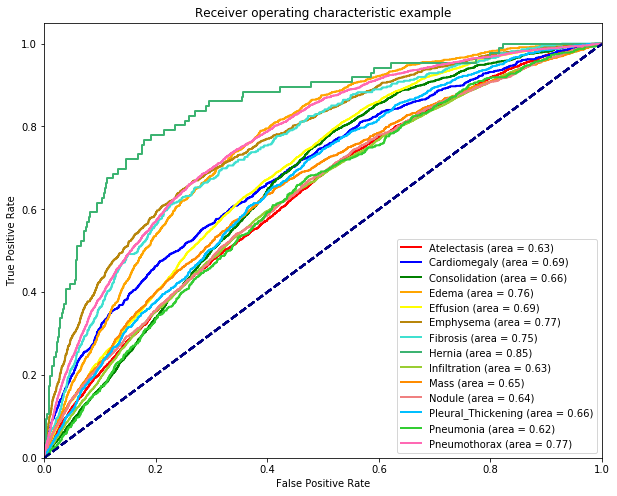

In [0]:
test_auc = get_acc_auc(test_results, class_names)
plot_auc(test_auc, PATH_OUTPUT)
